
# Fake News Detection & Explainability — Demo Notebook

This notebook is meant to **synthesize all major components of the project** in a
single place, roughly mirroring the order of the final presentation:

1. Datasets & exploratory analysis (Kaggle + LIAR)
2. Baselines vs DistilBERT performance
3. Layer-wise probing of DistilBERT
4. Explainability: IG, LIME, SHAP (pre-computed JSONL)
5. Live demo on a new LIAR-style claim:
   - prediction + confidence
   - IG / LIME / SHAP explanations
   - last-layer attention visualization

The notebook is **read-only with respect to heavy compute**:
we re-use trained models and pre-computed metrics instead of re-training.



In [1]:
# %%
import os
import json
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import shap
from lime.lime_text import LimeTextExplainer

# Make plots look like "Person 1" style: clean, with strong colors and outlines
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

PALETTE = sns.color_palette("Set2")
COLOR_FAKE = PALETTE[0]       # reddish / orange
COLOR_REAL = PALETTE[1]       # bluish / teal
COLOR_BASELINE = PALETTE[2]
COLOR_DISTILBERT = PALETTE[3]
COLOR_OTHER = PALETTE[4]

PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data" / "processed"
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
METRICS_DIR = ARTIFACTS_DIR / "metrics"
EXPL_DIR = ARTIFACTS_DIR / "explanations"
LAYERS_DIR = ARTIFACTS_DIR / "layers"

# Helper: small wrapper for bar plots with consistent style
def nice_bar(ax, x, y, color, label=None):
    bars = ax.bar(
        x,
        y,
        color=color,
        edgecolor="black",
        linewidth=0.8,
        label=label,
    )
    return bars

print("Root Directory:", PROJECT_ROOT)

/home/anton/.venvs/CP322_fake_news_xai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Root Directory: /home/anton/projects/CP322_fake_news_xai


## 1. Load Datasets & Metrics
We load:

- Processed train/val/test splits for **Kaggle** and **LIAR**
- Baseline results (`artifacts/metrics/baseline_results.csv`)
- DistilBERT results JSONs for both datasets

In [25]:
# --- Load processed CSVs ------------------------------------------------------
def load_split(dataset_name: str, split: str) -> pd.DataFrame:
    """
    dataset_name: 'kaggle' or 'liar'
    split: 'train' / 'val' / 'test'
    """
    path = DATA_DIR / f"{dataset_name}_{split}.csv"
    df = pd.read_csv(path)
    return df


kaggle_train = load_split("kaggle", "train")
kaggle_val = load_split("kaggle", "val")
kaggle_test = load_split("kaggle", "test")

liar_train = load_split("liar", "train")
liar_val = load_split("liar", "val")
liar_test = load_split("liar", "test")

kaggle_train.head(), liar_train.head()

(                                                text  label
 0  trump eyes flexible islamic state war fund, gu...      1
 1  tillerson takes tough line on russia, open to ...      1
 2  u.s. watching piracy increase off somalia, see...      1
 3  italy 5star party keeps option on euro referen...      1
 4  tanzania offers reward for arrest of antigraft...      1,
                                                 text  label
 0  romneycare sent costs spiraling out of control...      0
 1  if you take the population growth here in virg...      1
 2  the state of georgia lost 16 percent of its em...      1
 3  rhode island didnt ratify the 13th amendment t...      0
 4  today, you cant rely on the retirement fund fo...      0)

In [26]:
# --- Load baseline and DistilBERT metrics ------------------------------------
baseline_path = METRICS_DIR / "baseline_results.csv"
baseline_df = pd.read_csv(baseline_path)

# Expected DistilBERT metric files
distil_kaggle_path = METRICS_DIR / "distilbert_kaggle_fake_news_results.json"
distil_liar_path = METRICS_DIR / "distilbert_liar_results.json"

with open(distil_kaggle_path, "r") as f:
    distil_kaggle = json.load(f)

with open(distil_liar_path, "r") as f:
    distil_liar = json.load(f)

distil_kaggle, distil_liar

({'dataset': 'kaggle_fake_news',
  'model': 'distilbert-base-uncased',
  'test_accuracy': 0.9992315573770492,
  'test_f1': 0.9992917847025495,
  'test_precision': 0.9990559358036346,
  'test_recall': 0.9995277449822905,
  'test_loss': 0.003635258413851261,
  'hyperparameters': {'learning_rate': 2e-05,
   'batch_size': 16,
   'epochs': 3,
   'max_length': 512,
   'weight_decay': 0.01,
   'warmup_steps': 500}},
 {'dataset': 'liar',
  'model': 'distilbert-base-uncased',
  'test_accuracy': 0.6124458448207956,
  'test_f1': 0.7088757396449704,
  'test_precision': 0.6109127995920449,
  'test_recall': 0.8442565186751233,
  'test_loss': 0.6933155059814453,
  'hyperparameters': {'learning_rate': 3e-05,
   'batch_size': 32,
   'epochs': 5,
   'max_length': 128,
   'weight_decay': 0.01,
   'warmup_steps': 200}})

## 2. Exploratory Data Analysis (Person 1 style)

Here we reproduce and extend Person 1's analyses:

1. Dataset sizes & label distributions
2. Top 20 **content words** in each dataset
3. Marker words that strongly differentiate fake vs real news

In [27]:
def infer_text_column(df: pd.DataFrame) -> str:
    """
    Try to guess the main text column of a processed dataframe.
    Adjust if your actual column names differ.
    """
    for cand in ["text", "statement", "article", "content", "headline"]:
        if cand in df.columns:
            return cand
    # Fallback: last non-label column
    for col in df.columns:
        if "label" not in col.lower():
            return col
    raise ValueError("Could not infer text column.")


def infer_label_column(df: pd.DataFrame) -> str:
    for cand in ["label", "label_int", "label_id", "y"]:
        if cand in df.columns:
            return cand
    raise ValueError("Could not infer label column.")


k_text_col = infer_text_column(kaggle_train)
k_label_col = infer_label_column(kaggle_train)

l_text_col = infer_text_column(liar_train)
l_label_col = infer_label_column(liar_train)

k_text_col, k_label_col, l_text_col, l_label_col

('text', 'label', 'text', 'label')

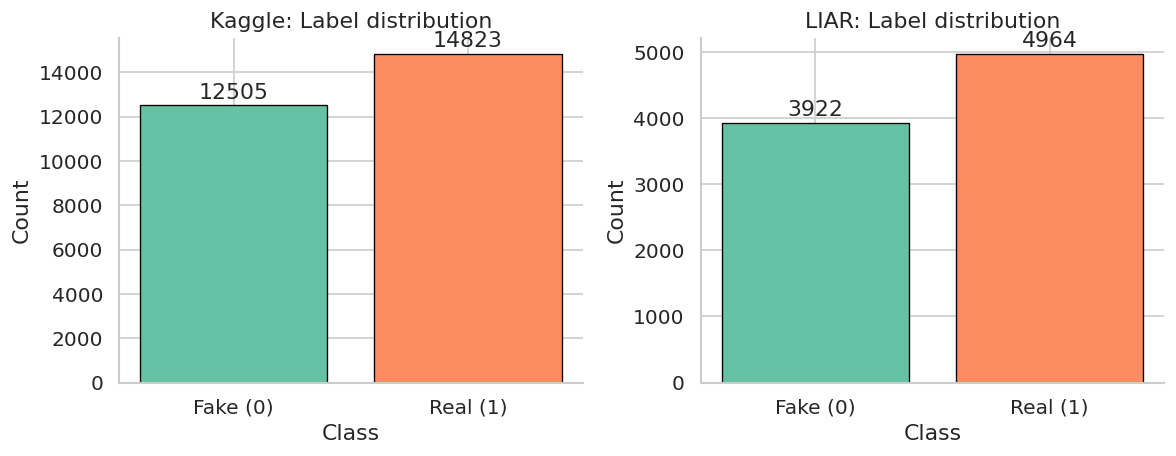

In [28]:
def plot_label_distribution(df, label_col, dataset_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4))
    value_counts = df[label_col].value_counts().sort_index()

    # Assume 0 = fake, 1 = real
    idx = value_counts.index.tolist()
    labels = ["Fake (0)", "Real (1)"]
    colors = [COLOR_FAKE, COLOR_REAL]

    nice_bar(ax, labels, value_counts.values, color=colors)
    ax.set_title(f"{dataset_name}: Label distribution")
    ax.set_ylabel("Count")
    ax.set_xlabel("Class")
    for i, v in enumerate(value_counts.values):
        ax.text(i, v + 0.01 * max(value_counts.values), f"{v}", ha="center", va="bottom")

    return ax


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_label_distribution(kaggle_train, k_label_col, "Kaggle", ax=axes[0])
plot_label_distribution(liar_train, l_label_col, "LIAR", ax=axes[1])
plt.tight_layout()
plt.show()

/tmp/ipykernel_1157407/2000689796.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=60, ha="right")
/tmp/ipykernel_1157407/2000689796.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=60, ha="right")


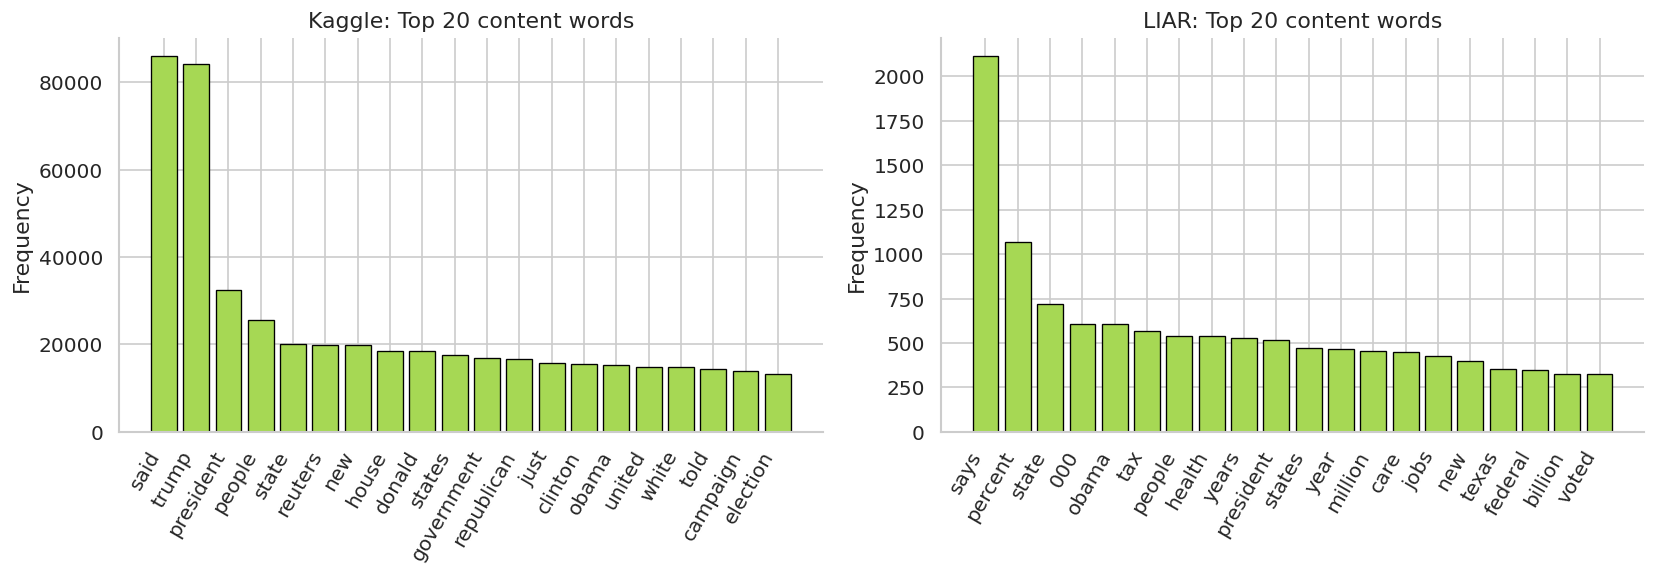

In [29]:
def top_content_words(df, text_col, top_k=20, stop_words="english"):
    """
    Return (words, counts) for top_k content words in the dataframe.
    Uses sklearn CountVectorizer (bag-of-words) with stopword removal.
    """
    vectorizer = CountVectorizer(stop_words=stop_words, min_df=5)
    X = vectorizer.fit_transform(df[text_col].astype(str).values)
    counts = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vectorizer.get_feature_names_out())
    order = np.argsort(counts)[::-1][:top_k]
    return vocab[order], counts[order]


def plot_top_content_words(df, text_col, dataset_name, ax=None, top_k=20):
    words, counts = top_content_words(df, text_col, top_k=top_k)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    nice_bar(ax, words, counts, color=COLOR_OTHER)
    ax.set_title(f"{dataset_name}: Top {top_k} content words")
    ax.set_ylabel("Frequency")
    ax.set_xticklabels(words, rotation=60, ha="right")
    return ax


fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_top_content_words(kaggle_train, k_text_col, "Kaggle", ax=axes[0], top_k=20)
plot_top_content_words(liar_train, l_text_col, "LIAR", ax=axes[1], top_k=20)
plt.tight_layout()
plt.show()

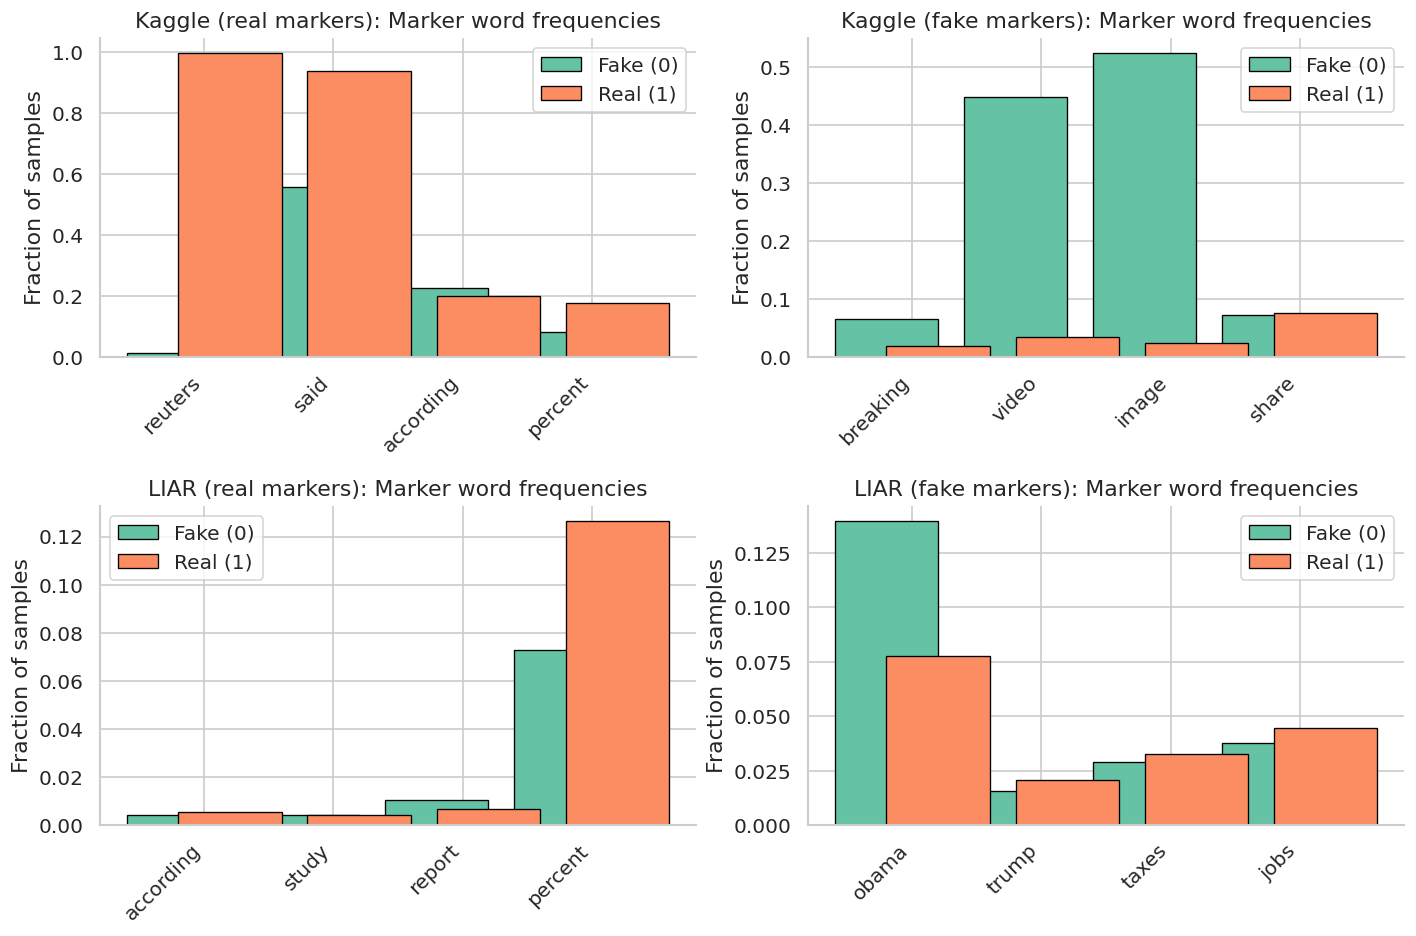

In [30]:
# "Marker" words that strongly indicate fake vs real.
# You can tweak this list to exactly match Person 1's choices.
KAGGLE_MARKERS_REAL = ["reuters", "said", "according", "percent"]
KAGGLE_MARKERS_FAKE = ["breaking", "video", "image", "share"]

LIAR_MARKERS_REAL = ["according", "study", "report", "percent"]
LIAR_MARKERS_FAKE = ["obama", "trump", "taxes", "jobs"]


def marker_frequencies(df, text_col, label_col, markers):
    """
    For each marker word, compute frequency per class (fraction of samples containing the word).
    Returns:
      markers: list of marker strings
      freq_fake, freq_real: arrays of frequencies
    """
    texts = df[text_col].astype(str).str.lower().values
    labels = df[label_col].values

    freq_fake = []
    freq_real = []

    for m in markers:
        m = m.lower()
        contains = np.array([m in t for t in texts])
        fake_mask = labels == 0
        real_mask = labels == 1

        freq_fake.append((contains & fake_mask).sum() / max(1, fake_mask.sum()))
        freq_real.append((contains & real_mask).sum() / max(1, real_mask.sum()))

    return markers, np.array(freq_fake), np.array(freq_real)


def plot_marker_frequencies(df, text_col, label_col, markers, dataset_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))

    markers, f_fake, f_real = marker_frequencies(df, text_col, label_col, markers)
    x = np.arange(len(markers))
    width = 0.4

    nice_bar(ax, x - width / 2, f_fake, color=COLOR_FAKE, label="Fake (0)")
    nice_bar(ax, x + width / 2, f_real, color=COLOR_REAL, label="Real (1)")

    ax.set_xticks(x)
    ax.set_xticklabels(markers, rotation=45, ha="right")
    ax.set_ylabel("Fraction of samples")
    ax.set_title(f"{dataset_name}: Marker word frequencies")
    ax.legend()
    return ax


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_marker_frequencies(
    kaggle_train, k_text_col, k_label_col, KAGGLE_MARKERS_REAL, "Kaggle (real markers)", ax=axes[0, 0]
)
plot_marker_frequencies(
    kaggle_train, k_text_col, k_label_col, KAGGLE_MARKERS_FAKE, "Kaggle (fake markers)", ax=axes[0, 1]
)

plot_marker_frequencies(
    liar_train, l_text_col, l_label_col, LIAR_MARKERS_REAL, "LIAR (real markers)", ax=axes[1, 0]
)
plot_marker_frequencies(
    liar_train, l_text_col, l_label_col, LIAR_MARKERS_FAKE, "LIAR (fake markers)", ax=axes[1, 1]
)

plt.tight_layout()
plt.show()

## 3. Baselines vs DistilBERT

Now we compare traditional TF-IDF baselines against DistilBERT
for each dataset (using saved metrics).

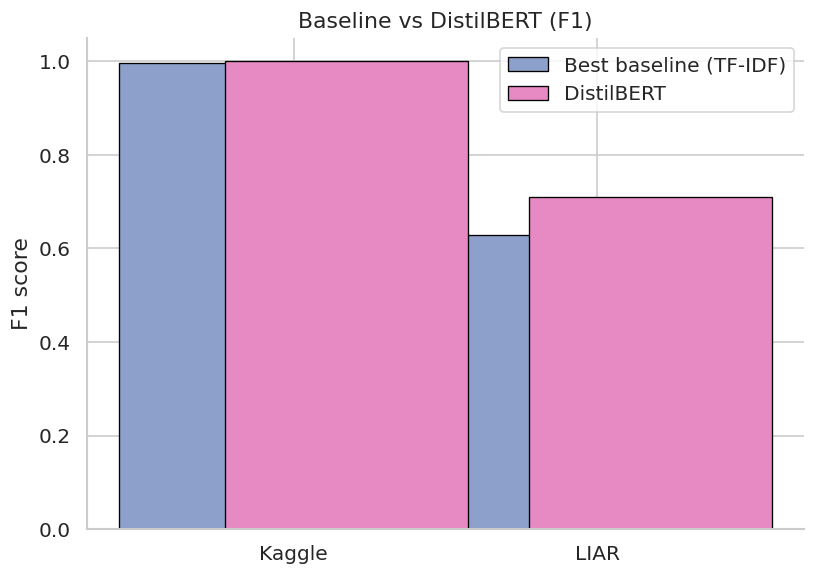

In [31]:
# Inspect baselines
baseline_df.head()

# Get best baseline per dataset by F1
def best_baseline_for(dataset_name_pretty: str):
    """dataset_name_pretty: e.g., 'Kaggle' or 'LIAR' (matches baseline_results.csv)"""
    sub = baseline_df[baseline_df["dataset"] == dataset_name_pretty]
    if sub.empty:
        return None
    best_row = sub.sort_values("f1", ascending=False).iloc[0]
    return {
        "model": best_row["model"],
        "f1": best_row["f1"],
        "accuracy": best_row.get("accuracy", np.nan),
    }


best_kaggle = best_baseline_for("Kaggle")
best_liar = best_baseline_for("LIAR")

best_kaggle, best_liar

# Prepare data for F1 comparison bar chart
datasets = ["Kaggle", "LIAR"]
baseline_f1 = [
    best_kaggle["f1"] if best_kaggle is not None else np.nan,
    best_liar["f1"] if best_liar is not None else np.nan,
]
distil_f1 = [distil_kaggle["test_f1"], distil_liar["test_f1"]]

x = np.arange(len(datasets))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 5))
nice_bar(ax, x - width / 2, baseline_f1, color=COLOR_BASELINE, label="Best baseline (TF-IDF)")
nice_bar(ax, x + width / 2, distil_f1, color=COLOR_DISTILBERT, label="DistilBERT")

ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.set_ylabel("F1 score")
ax.set_ylim(0, 1.05)
ax.set_title("Baseline vs DistilBERT (F1)")
ax.legend()
plt.tight_layout()
plt.show()

## 4. Layer-wise Probing

We use **logistic regression probes** on frozen hidden states to see
**where in the transformer** the fake/real distinction becomes linearly separable.

The probe results are stored in JSON files like:

- `artifacts/layers/kaggle_layer_probes.json`
- `artifacts/layers/liar_layer_probes.json`

Schema (per your example):

```json
{
  "n_samples": 2000,
  "n_layers": 7,
  "hidden_dim": 768,
  "layers": [0,1,2,3,4,5,6],
  "accuracy": [...],
  "f1": [...]
}

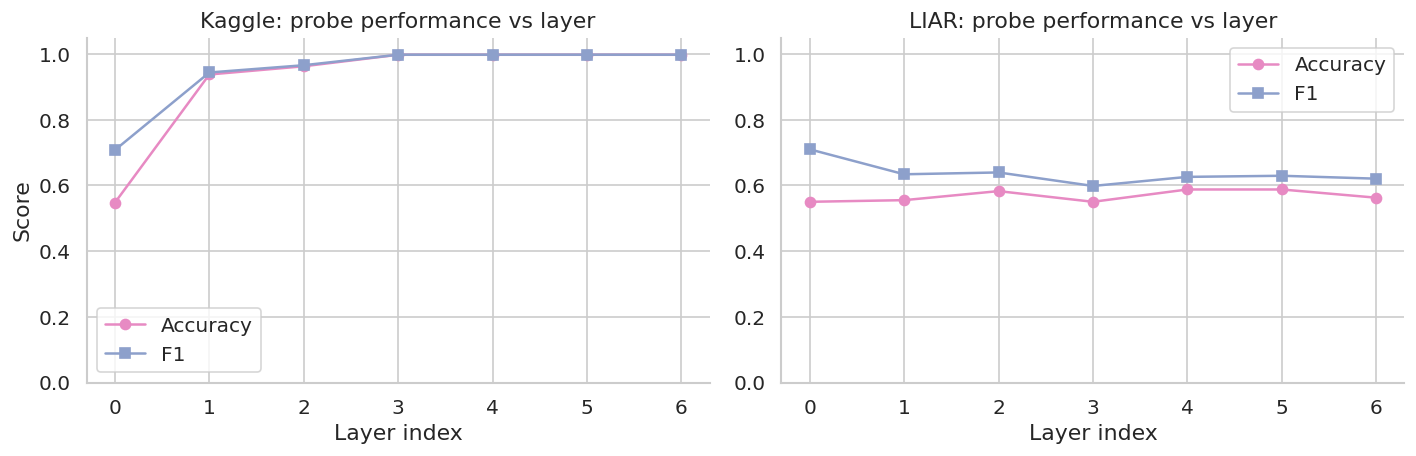

Kaggle best layer (by F1): 3 0.9977116704805492
LIAR   best layer (by F1): 0 0.7096774193548387


In [32]:
def load_layer_probe_results_new_schema(path: Path):
    with open(path, "r") as f:
        data = json.load(f)

    layers = np.array(data["layers"])
    acc = np.array(data["accuracy"], dtype=float)
    f1 = np.array(data["f1"], dtype=float)
    return layers, acc, f1, data


kaggle_probe_path = LAYERS_DIR / "kaggle_layer_probes.json"
liar_probe_path = LAYERS_DIR / "liar_layer_probes.json"

k_layers, k_acc, k_f1, _ = load_layer_probe_results_new_schema(kaggle_probe_path)
l_layers, l_acc, l_f1, _ = load_layer_probe_results_new_schema(liar_probe_path)

k_layers, k_acc, l_layers, l_acc

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(k_layers, k_acc, marker="o", color=COLOR_DISTILBERT, label="Accuracy")
axes[0].plot(k_layers, k_f1, marker="s", color=COLOR_BASELINE, label="F1")
axes[0].set_title("Kaggle: probe performance vs layer")
axes[0].set_xlabel("Layer index")
axes[0].set_ylabel("Score")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

axes[1].plot(l_layers, l_acc, marker="o", color=COLOR_DISTILBERT, label="Accuracy")
axes[1].plot(l_layers, l_f1, marker="s", color=COLOR_BASELINE, label="F1")
axes[1].set_title("LIAR: probe performance vs layer")
axes[1].set_xlabel("Layer index")
axes[1].set_ylim(0, 1.05)
axes[1].legend()

plt.tight_layout()
plt.show()

print("Kaggle best layer (by F1):", k_layers[np.argmax(k_f1)], k_f1.max())
print("LIAR   best layer (by F1):", l_layers[np.argmax(l_f1)], l_f1.max())

## 5. Explanation Methods (IG / LIME / SHAP)

We now inspect the **pre-computed explanations** stored as JSONL:

- `kaggle_ig.jsonl`, `kaggle_lime.jsonl`, `kaggle_shap.jsonl`
- `liar_ig.jsonl`, `liar_lime.jsonl`, `liar_shap.jsonl`

Each line has the schema you provided, e.g.:

```json
{
  "sample_id": 0,
  "text": "...",
  "tokens": [...],
  "importances": [...],
  "pred_label": 1,
  "true_label": 1,
  "dataset": "liar",
  "method": "ig"
}
```

In this section we:
- Load Integrated Gradients (IG), LIME, and SHAP explanations for both datasets.
- Select **one high-confidence real and fake example** from Kaggle and LIAR
  (our XAI pipeline already filtered to confident predictions when generating these files).
- For each selected sample, build a combined table of token importances from
  **all three methods**.
- Visualize the importances in **clustered bar charts**: one cluster per token
  (IG / LIME / SHAP bars side-by-side), using the same visual style as in the EDA plots.

In [5]:
def load_jsonl(path: Path):
    records = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rec = json.loads(line)
            records.append(rec)
    return records

def build_index(records):
    """
    Build {sample_id: record} dict for quick lookup.
    """
    idx = {}
    for r in records:
        sid = r.get("sample_id")
        if sid is not None:
            idx[sid] = r
    return idx

# ---- Load all explanation files ----
datasets = ["kaggle", "liar"]
methods = ["ig", "lime", "shap"]

explanations = {}  # (dataset, method) -> list[dict]
indices = {}       # (dataset, method) -> {sample_id: dict}

for ds in datasets:
    for m in methods:
        path = EXPL_DIR / f"{ds}_{m}.jsonl"
        if not path.exists():
            print(f"[warn] Missing explanations file: {path}")
            continue
        recs = load_jsonl(path)
        explanations[(ds, m)] = recs
        indices[(ds, m)] = build_index(recs)
        print(f"[info] Loaded {len(recs)} {m.upper()} explanations for {ds}")

def pick_sample_with_all_methods(ds: str, target_label: int):
    """
    For a given dataset and label (0=fake, 1=real),
    pick a sample_id that appears in IG, LIME, and SHAP files.
    Prefer samples whose true_label == target_label.
    """
    idx_ig   = indices.get((ds, "ig"), {})
    idx_lime = indices.get((ds, "lime"), {})
    idx_shap = indices.get((ds, "shap"), {})

    common_ids = set(idx_ig.keys()) & set(idx_lime.keys()) & set(idx_shap.keys())
    if not common_ids:
        raise ValueError(f"No common sample_ids across IG/LIME/SHAP for dataset={ds}")

    # Prefer IDs whose true_label matches the target
    def has_label(idx, sid, label):
        return idx[sid].get("true_label") == label

    candidates = [sid for sid in common_ids if has_label(idx_ig, sid, target_label)]
    if not candidates:
        # Fall back to any common id if none match label
        candidates = list(common_ids)

    # Deterministic but arbitrary: smallest id
    sample_id = sorted(candidates)[0]

    return {
        "sample_id": sample_id,
        "ig": idx_ig[sample_id],
        "lime": idx_lime[sample_id],
        "shap": idx_shap[sample_id]
    }

# ---- Select one fake + one real per dataset ----
selected_samples = {}  # (dataset, label) -> dict

for ds in datasets:
    for label in [0, 1]:
        try:
            recs = pick_sample_with_all_methods(ds, label)
            # Text is the same across methods; grab from IG
            text = recs["ig"].get("text", "")
            recs["text"] = text
            selected_samples[(ds, label)] = recs
        except Exception as e:
            print(f"[warn] Could not pick sample for {ds}, label={label}: {e}")

# ---- Print the four chosen texts ----
label_names = {0: "fake (0)", 1: "real (1)"}

for ds in datasets:
    for label in [0, 1]:
        key = (ds, label)
        if key not in selected_samples:
            continue
        info = selected_samples[key]
        print("\n" + "=" * 100)
        print(f"{ds.upper()} — {label_names[label]} — sample_id={info['sample_id']}")
        print("-" * 100)
        print(info["text"])

[info] Loaded 100 IG explanations for kaggle
[info] Loaded 100 LIME explanations for kaggle
[info] Loaded 100 SHAP explanations for kaggle
[info] Loaded 100 IG explanations for liar
[info] Loaded 100 LIME explanations for liar
[info] Loaded 100 SHAP explanations for liar

KAGGLE — fake (0) — sample_id=5
----------------------------------------------------------------------------------------------------
democrats spend big on this ad to expose trumps cold, dark heart video. the democratic super pac priorities usa is spending an unusually high 500,000 for a digital ad campaign featuring a powerful indictment of republican presidential nominee donald trump s cruelty towards disabled people.the ad, dante, features a 17yearold suffering from cancer and his reaction to trump s mockery of a disabled reporter.flashing cancer survivor tattoos on his forearms, dante latchman, 17, tells of surviving a rare spinalcord affliction that was diagnosed when he was 1. i ve spent my whole life fighting b

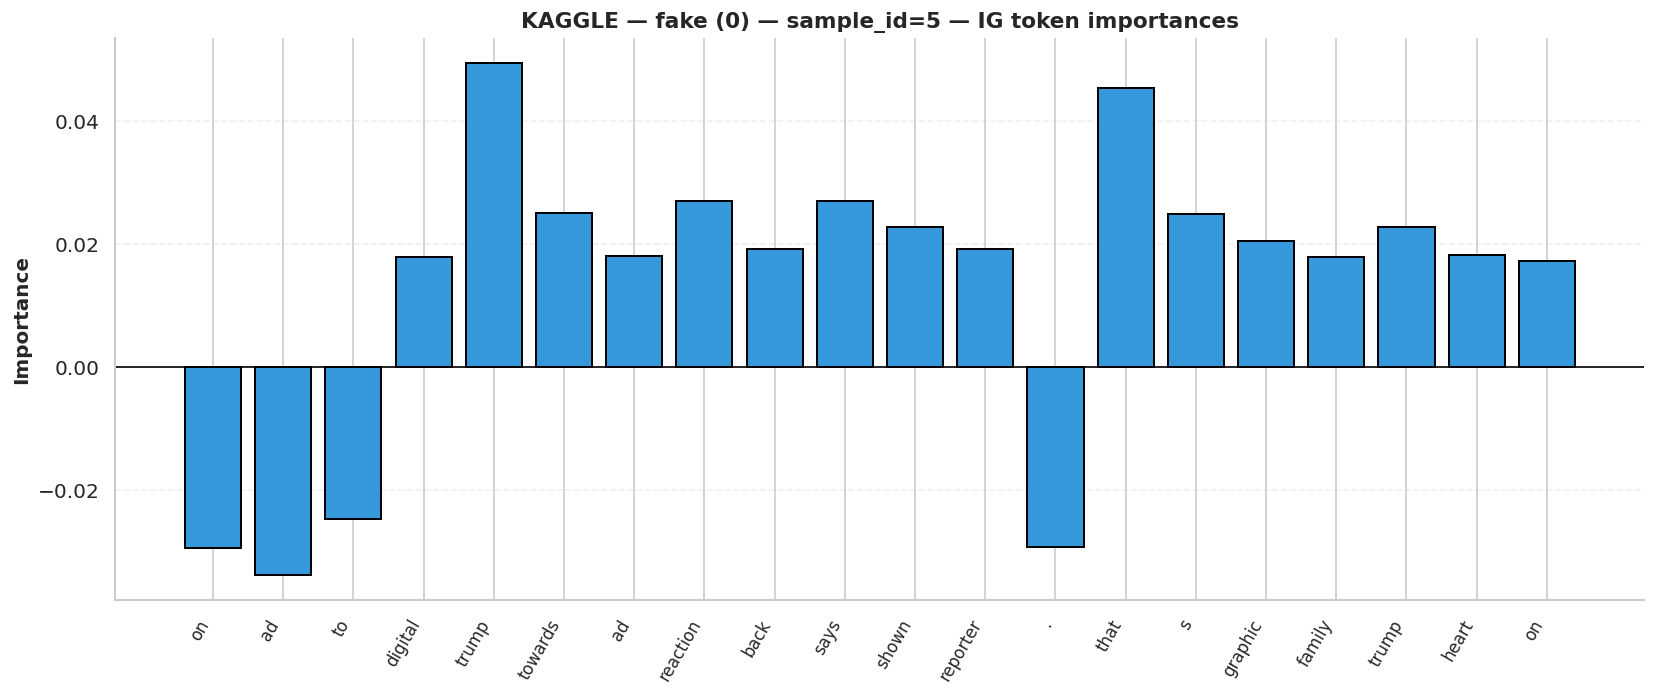

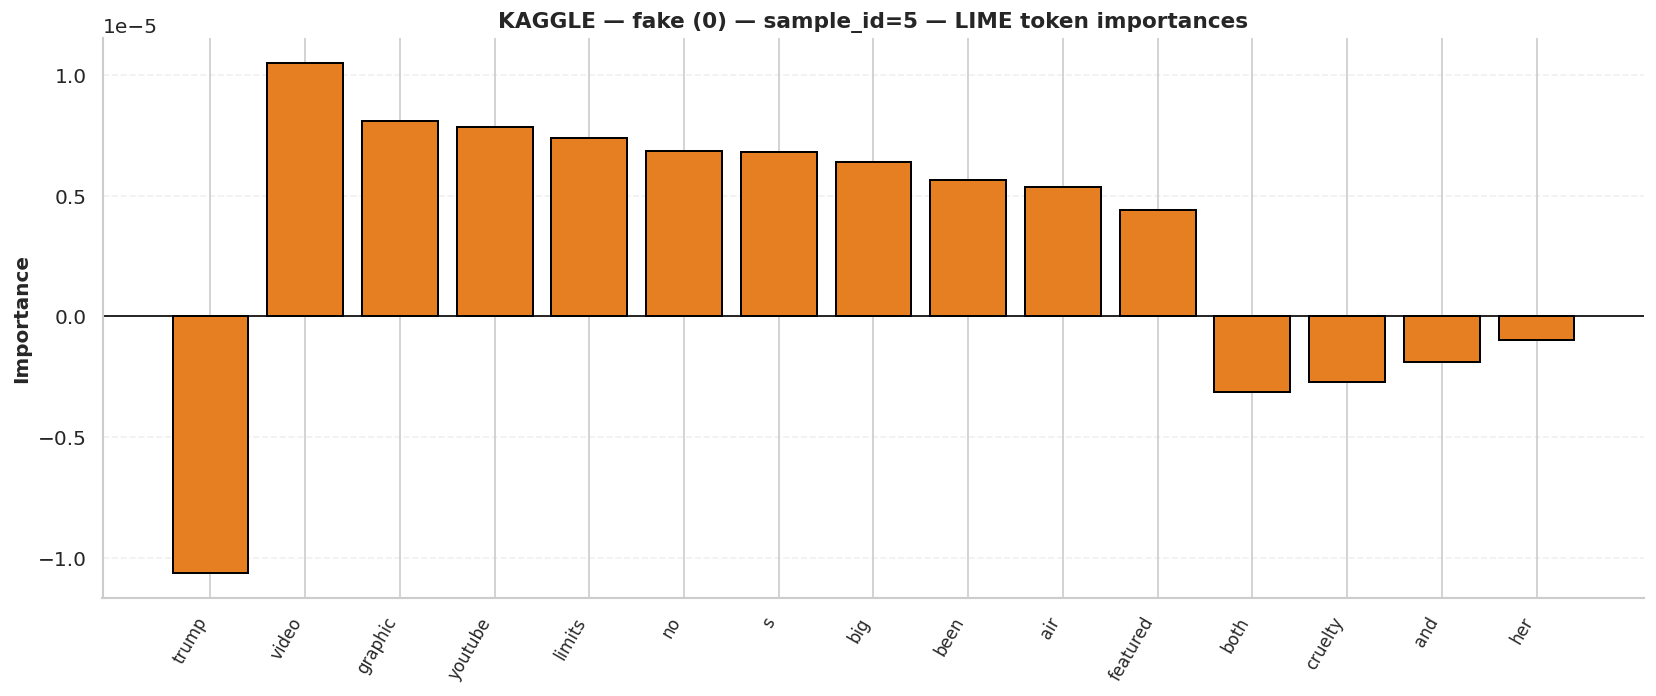

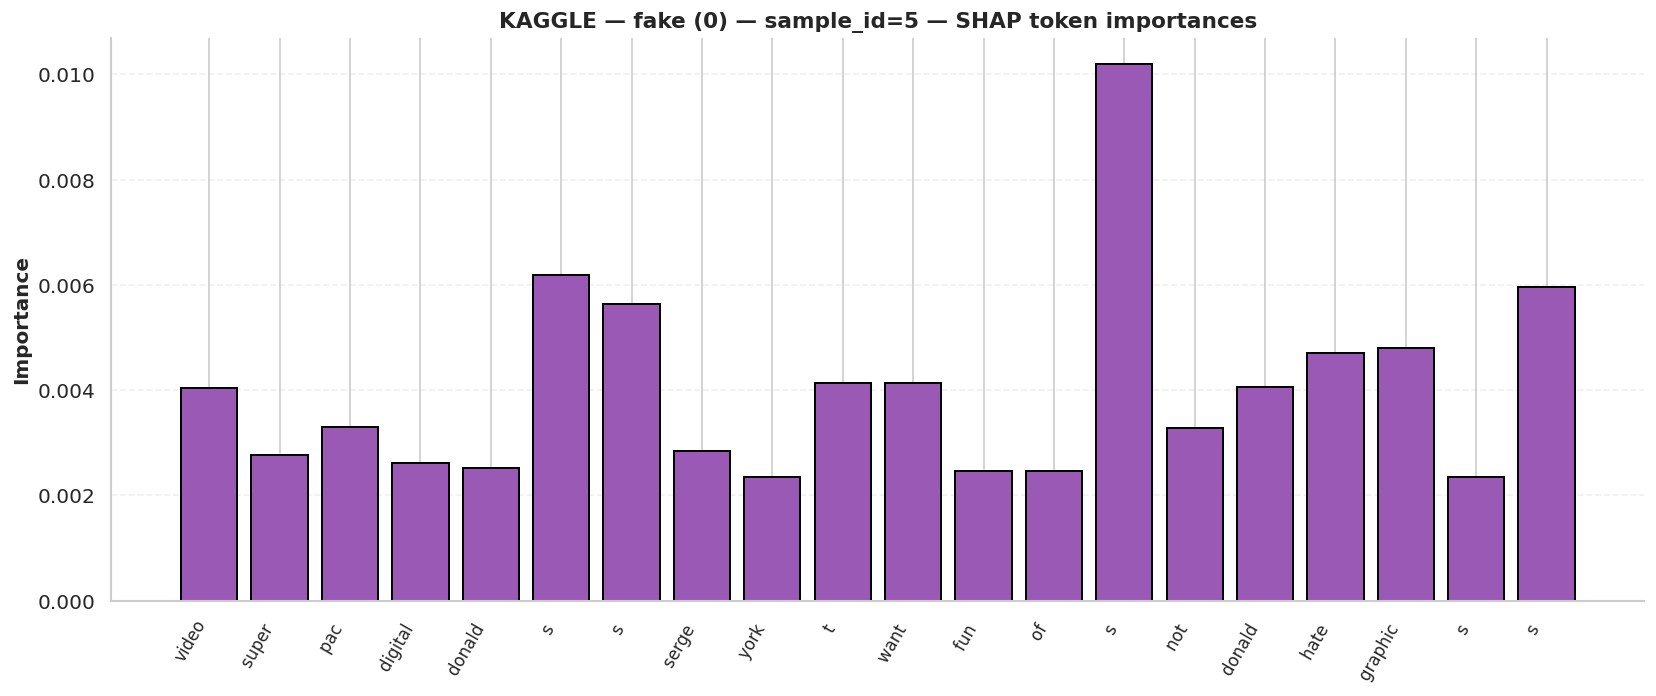

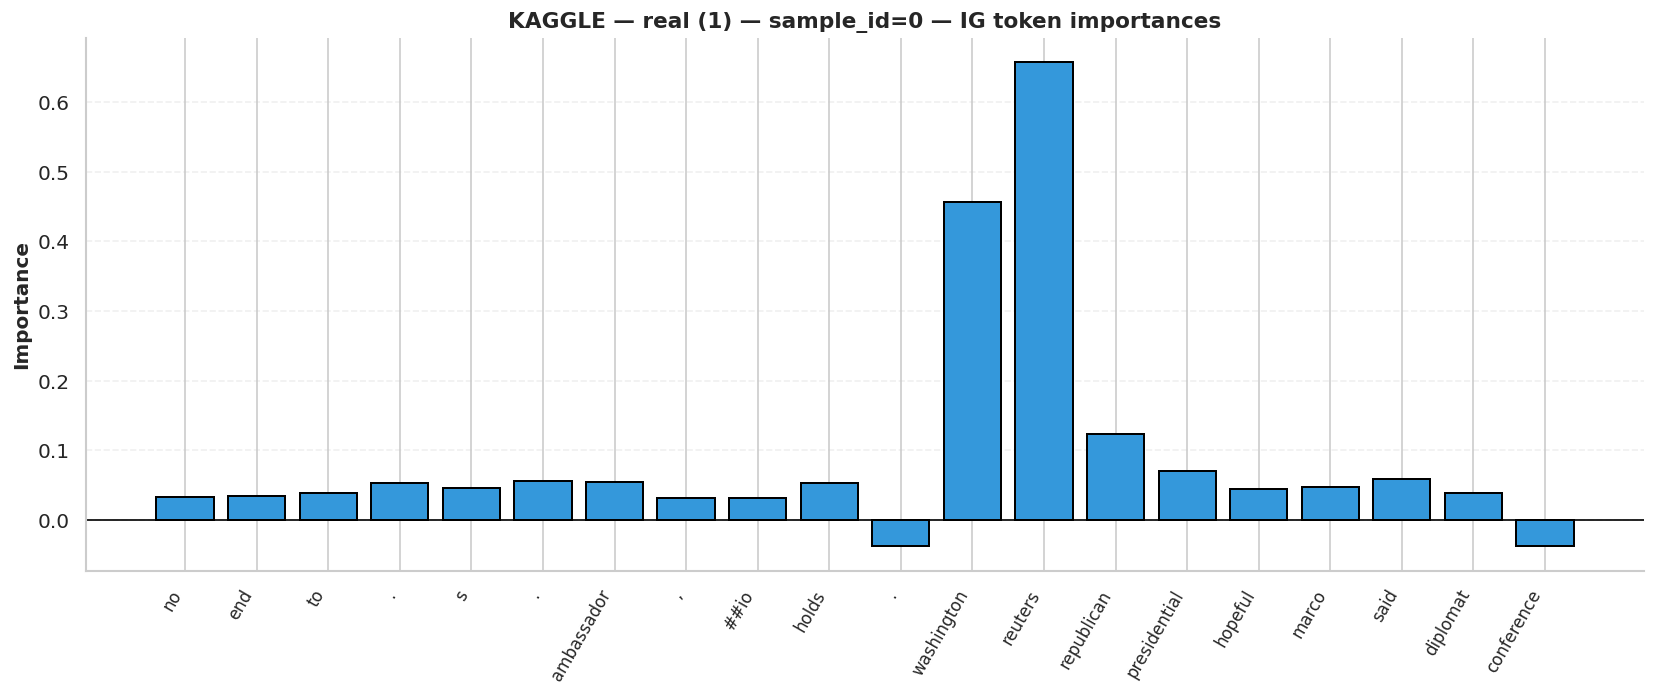

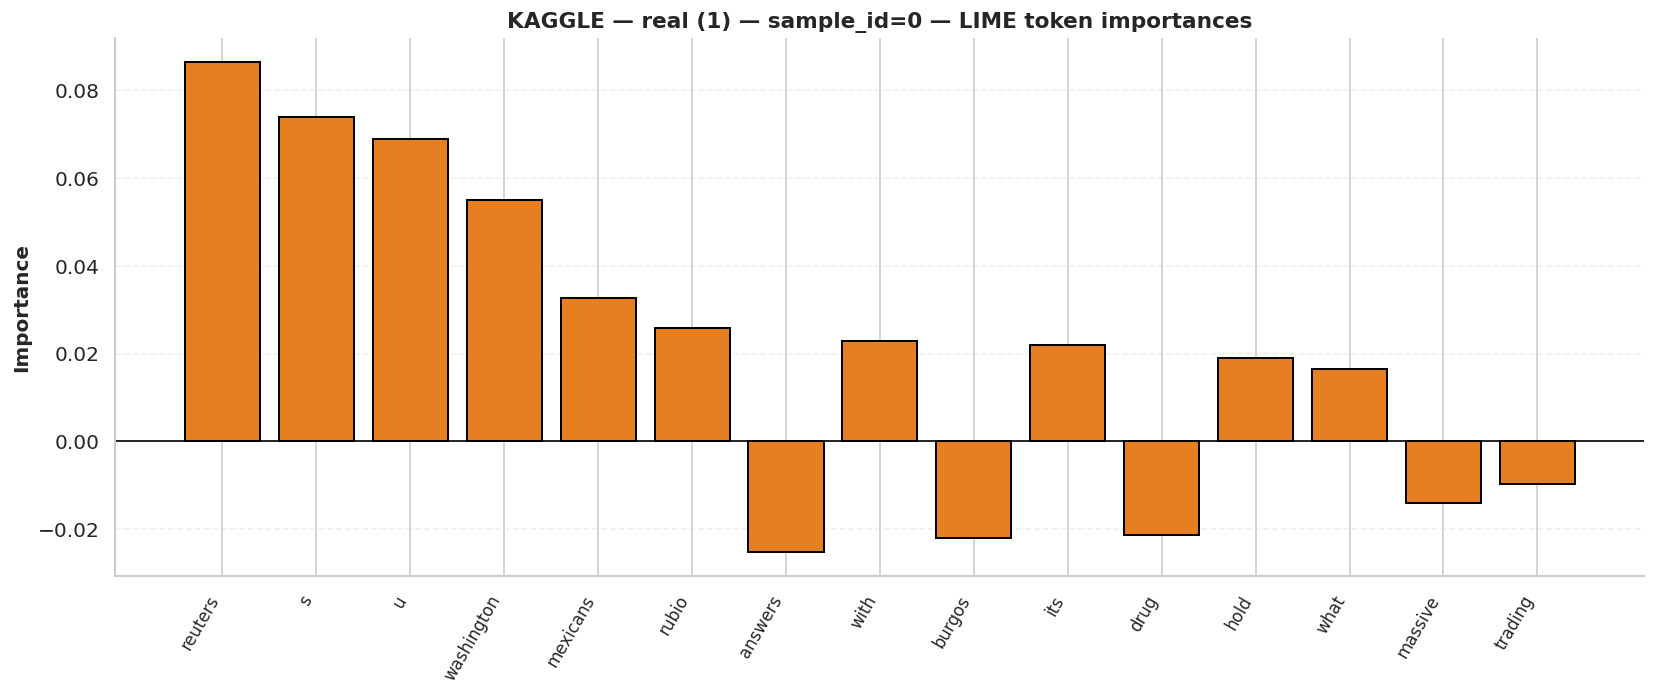

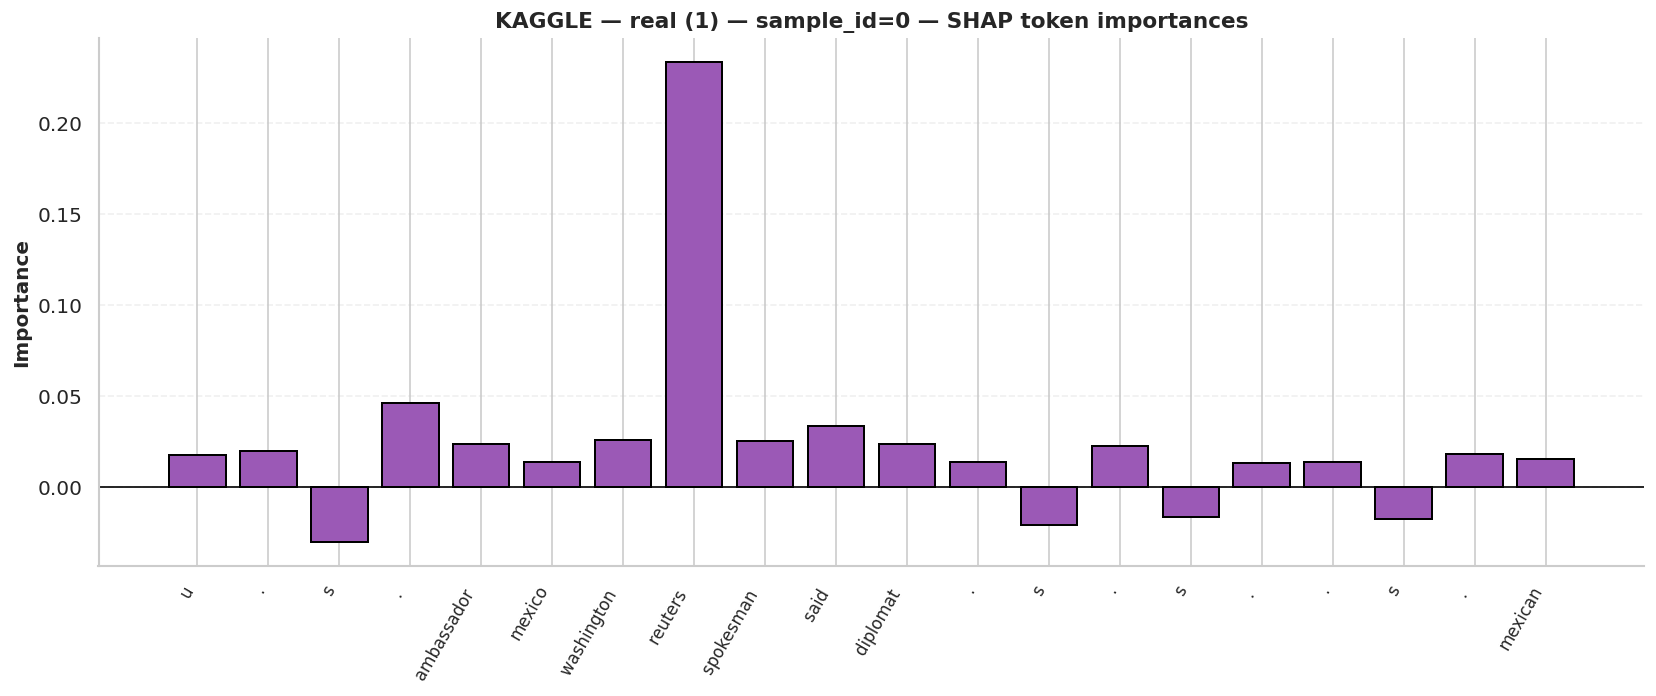

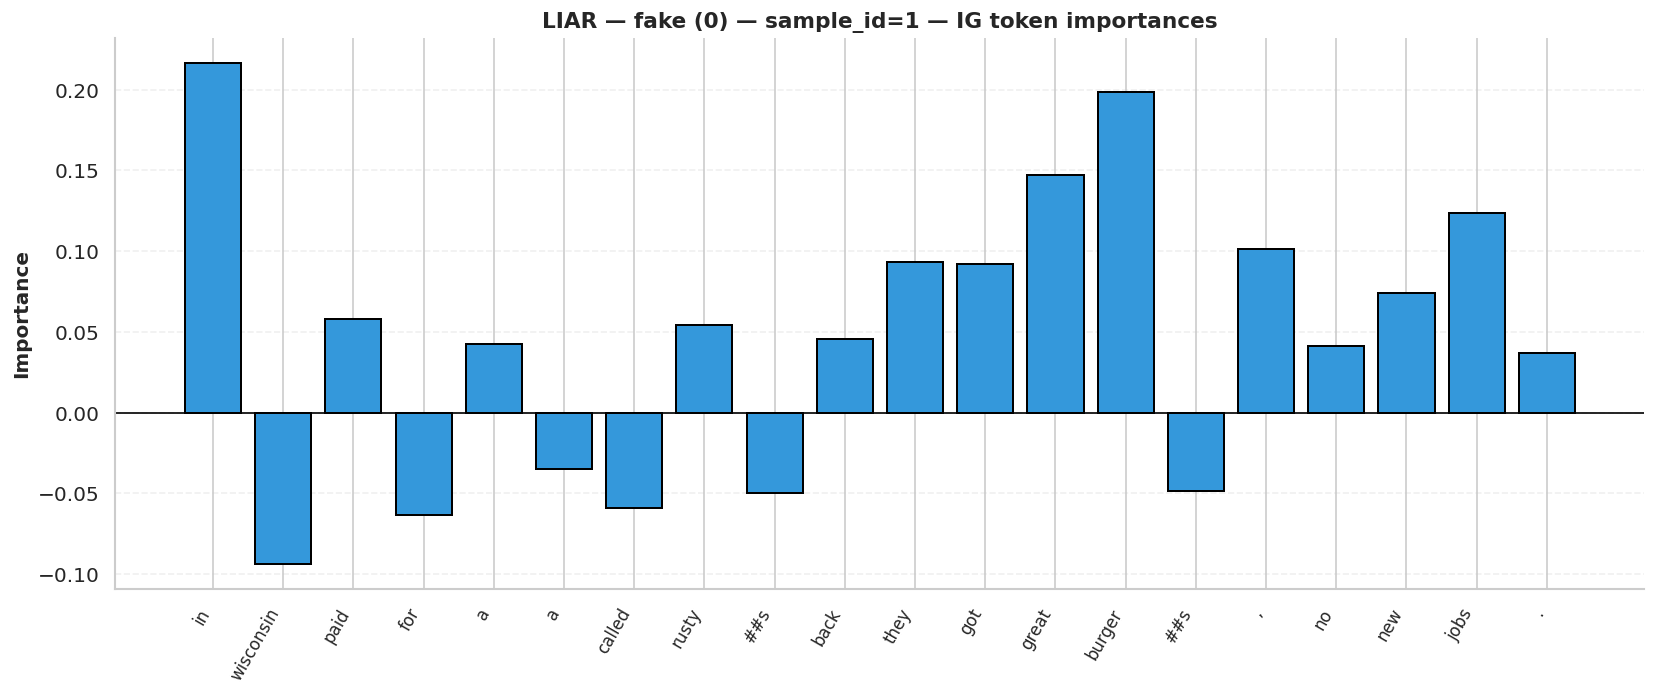

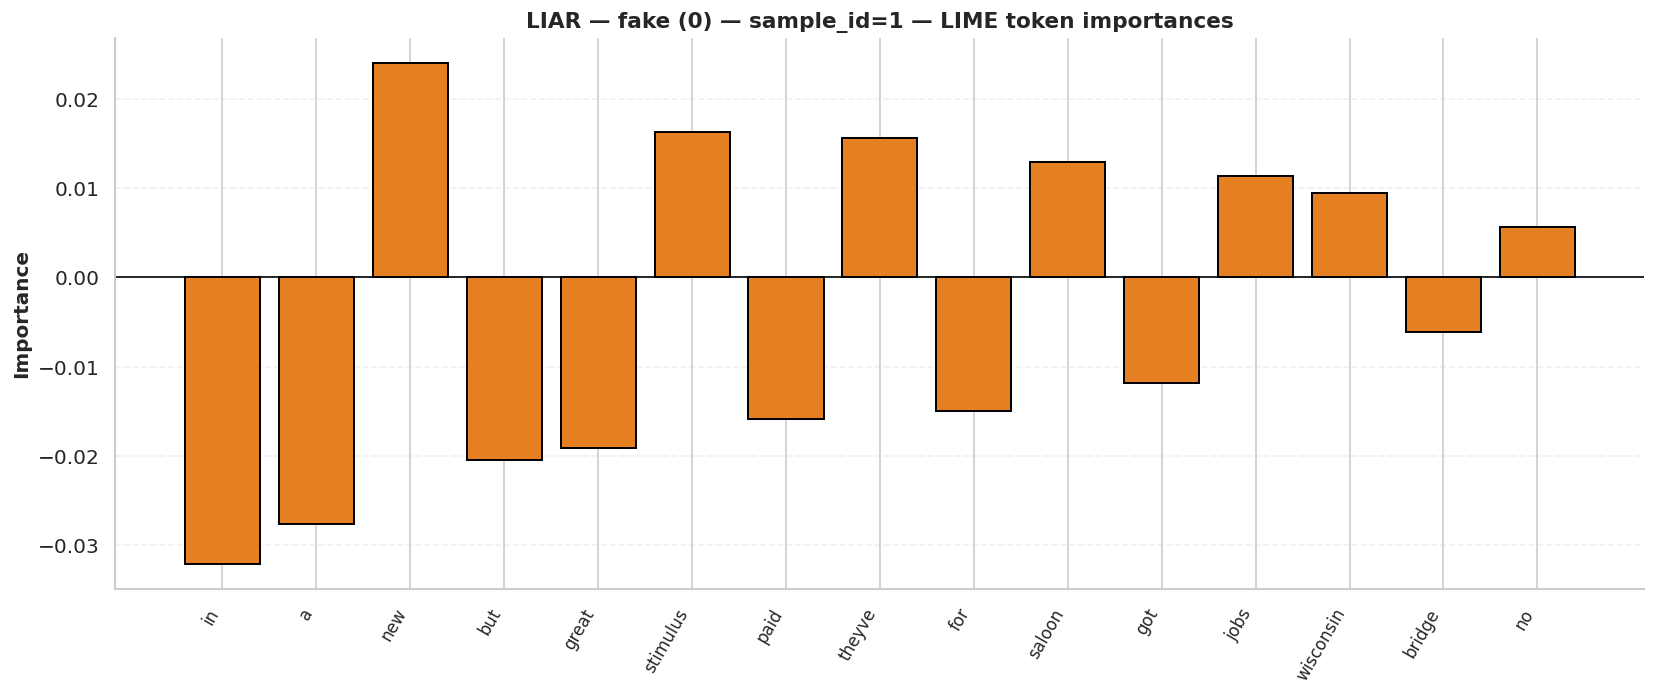

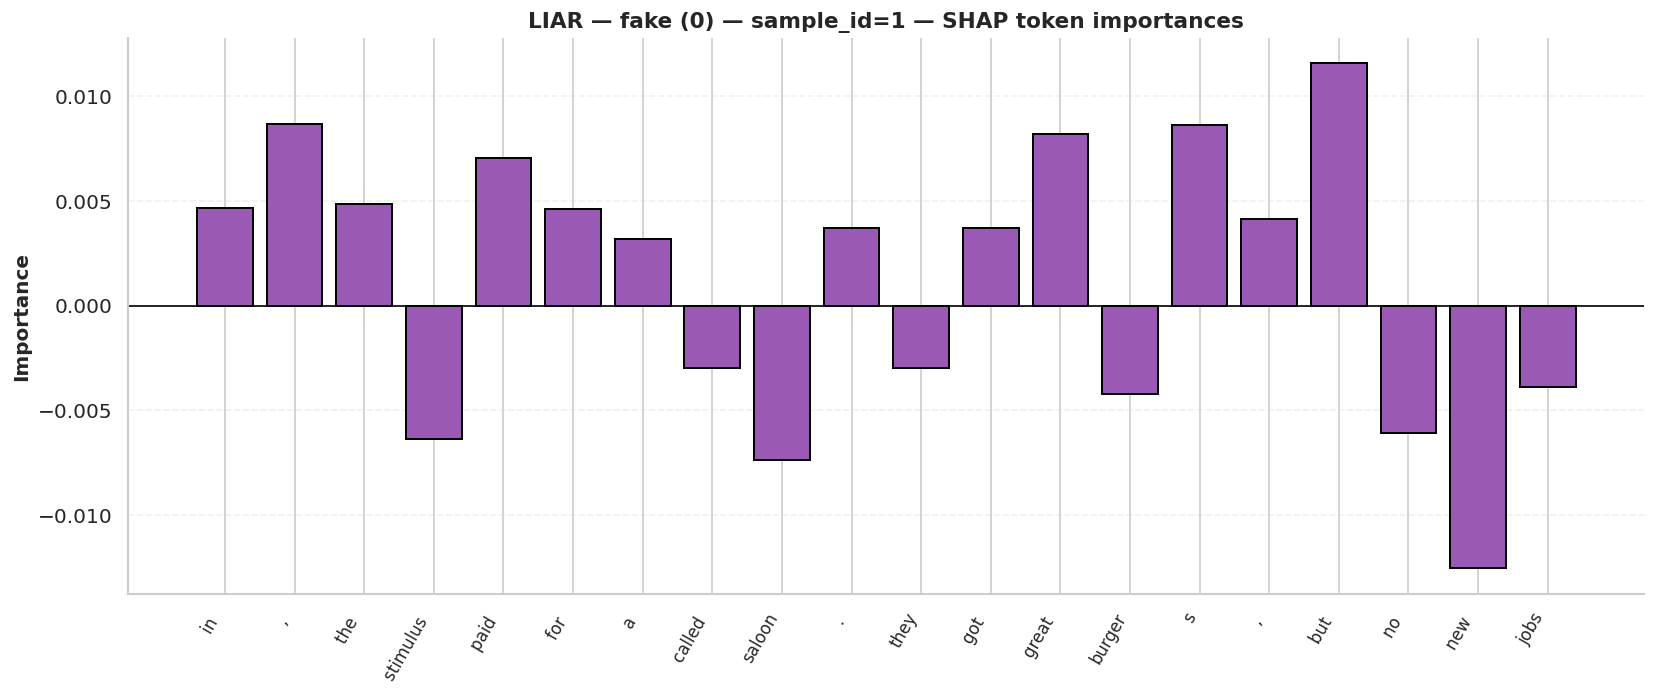

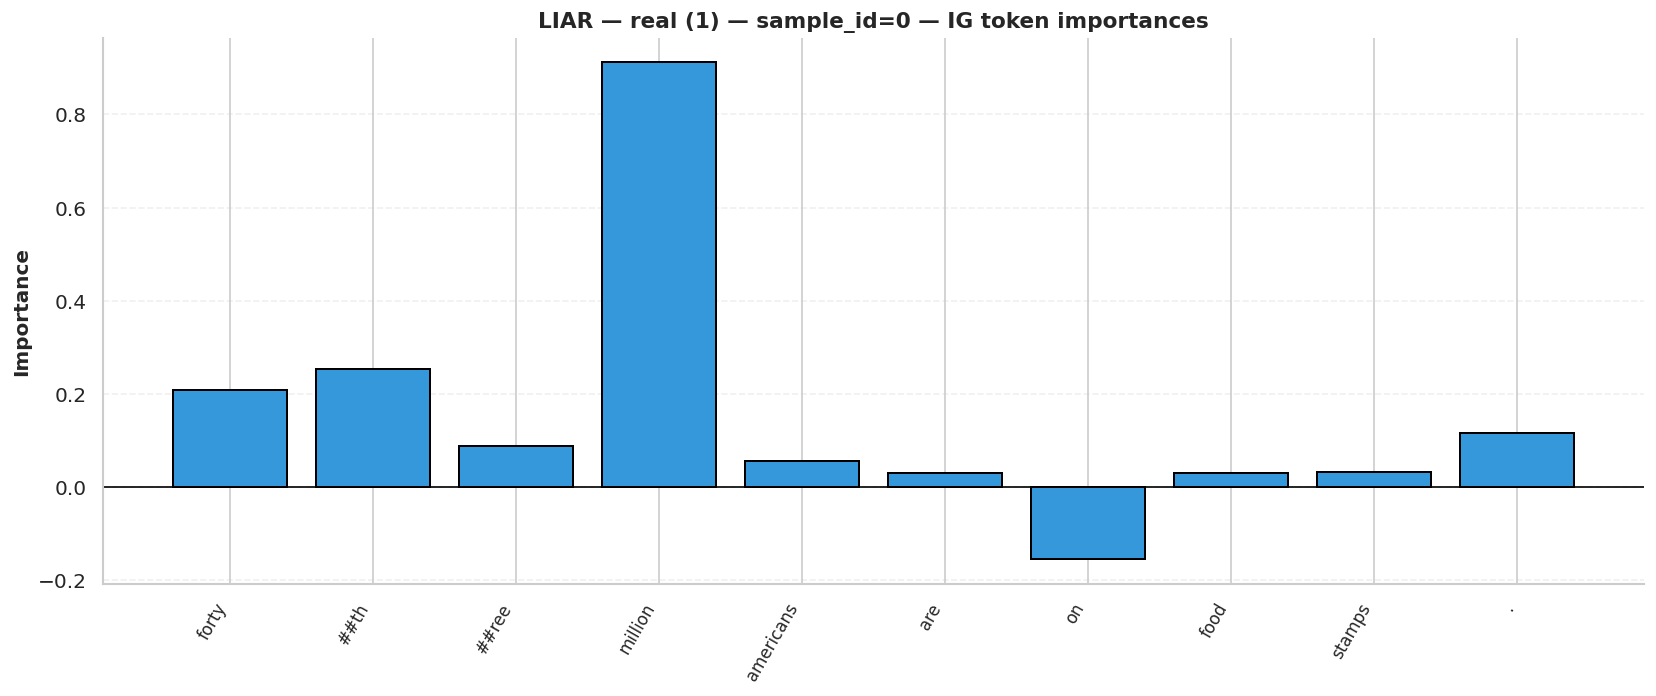

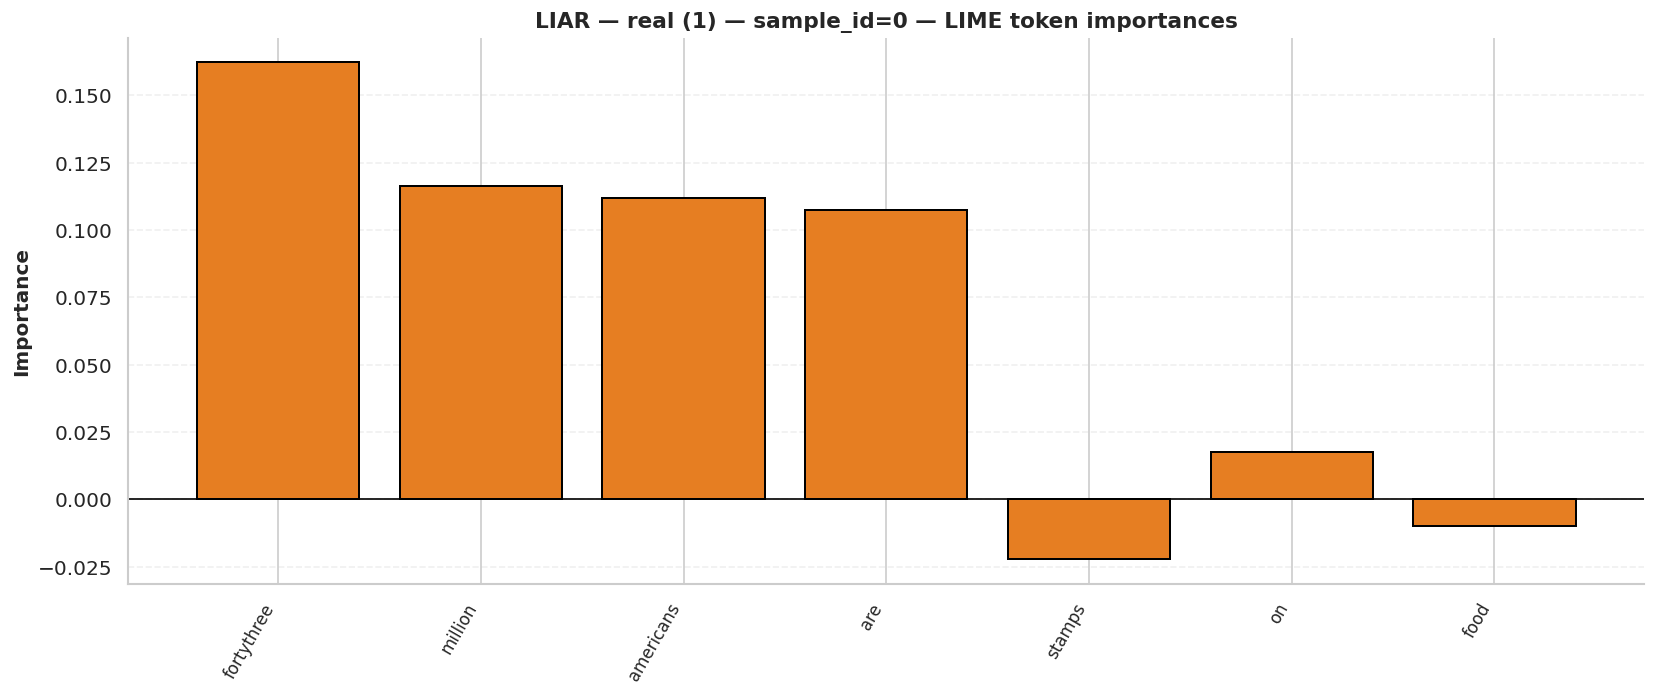

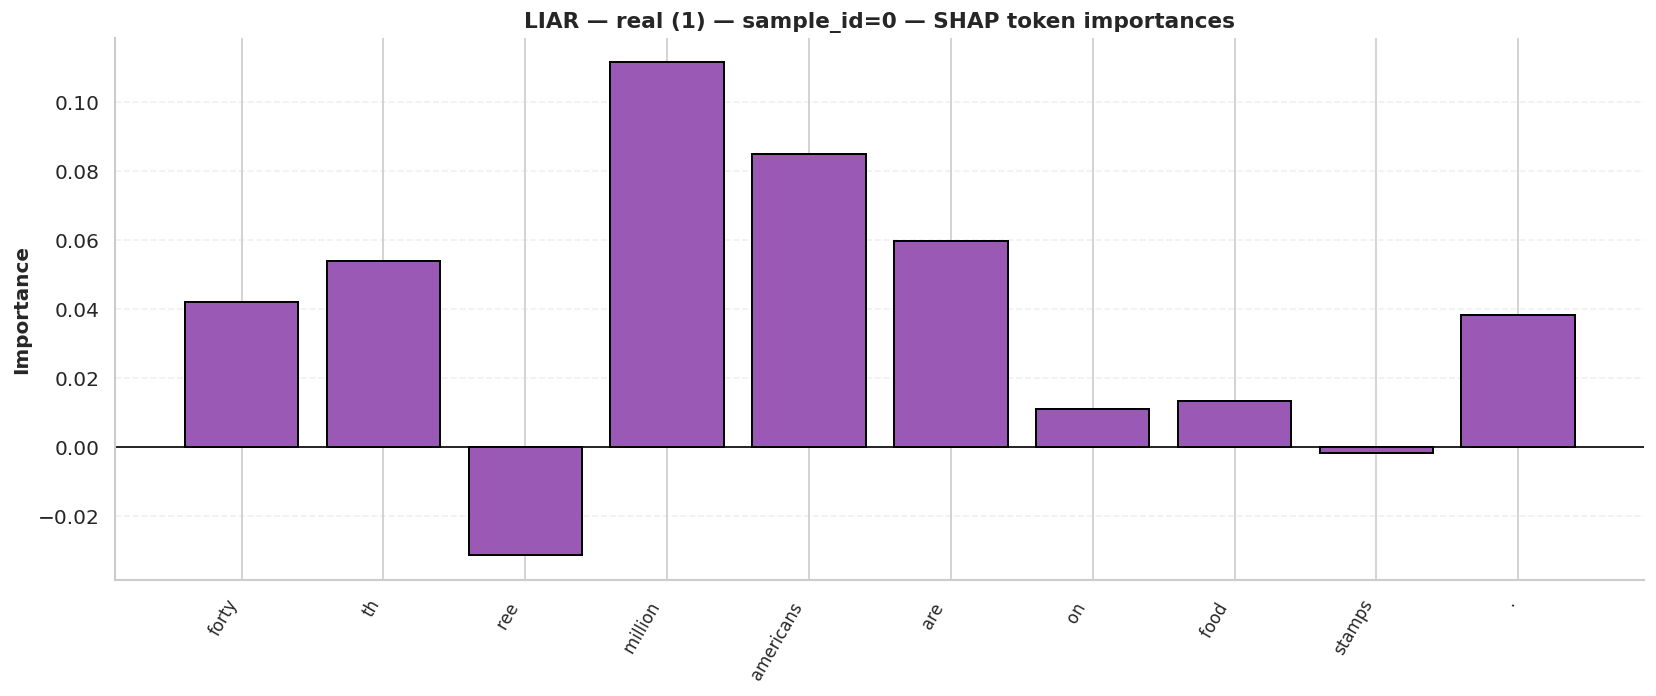

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Shared color scheme for methods (in same spirit as the EDA plots)
METHOD_COLORS = {
    "ig":   "#3498db",  # blue
    "lime": "#e67e22",  # orange
    "shap": "#9b59b6",  # purple
}

def extract_tokens_and_scores(expl_record):
    """
    Extract (tokens, importances) from an explanation record and
    filter out special tokens that we don't want to visualize.

    Supports IG / LIME / SHAP JSON schemas used in this project.
    """
    tokens = (
        expl_record.get("tokens")
        or expl_record.get("words")
        or expl_record.get("features")
    )
    importances = (
        expl_record.get("importances")
        or expl_record.get("scores")
        or expl_record.get("attributions")
        or expl_record.get("weights")
    )

    if tokens is None or importances is None:
        raise ValueError(
            f"Missing tokens/importances in explanation record keys={expl_record.keys()}"
        )

    tokens = list(tokens)
    importances = list(importances)

    # Truncate to common length
    n = min(len(tokens), len(importances))
    tokens = tokens[:n]
    importances = importances[:n]

    # Filter out special tokens and empty strings
    drop_set = {"[CLS]", "[SEP]", "[PAD]"}
    filtered_tokens = []
    filtered_imps = []
    for t, s in zip(tokens, importances):
        if t in drop_set or t == "" or str(t).isspace():
            continue
        filtered_tokens.append(t)
        filtered_imps.append(float(s))

    # Fallback: if we somehow removed everything, keep original
    if not filtered_tokens:
        filtered_tokens = tokens
        filtered_imps = [float(s) for s in importances]

    return filtered_tokens, np.array(filtered_imps, dtype=float)

def plot_token_importances(tokens, importances, title, top_k=15, color="#3498db"):
    """
    Plot token importances:
    - Select top_k tokens by absolute importance.
    - Display them in their ORIGINAL sequence order.

    tokens: list[str]
    importances: 1D np.array (signed)
    """
    tokens = list(tokens)
    importances = np.array(importances, dtype=float)

    if len(tokens) == 0:
        print(f"[warn] No tokens to plot for: {title}")
        return

    # --- select top-k indices by absolute value ---
    k = min(top_k, len(tokens))
    abs_imps = np.abs(importances)
    # indices of top-k (unsorted)
    topk_idx = np.argpartition(abs_imps, -k)[-k:]
    topk_idx_set = set(topk_idx.tolist())

    # --- keep tokens in ORIGINAL order, but only those in top-k ---
    sel_positions = []
    sel_tokens = []
    sel_imps = []
    for i, (tok, imp) in enumerate(zip(tokens, importances)):
        if i in topk_idx_set:
            sel_positions.append(i)
            sel_tokens.append(tok)
            sel_imps.append(imp)

    if not sel_tokens:
        print(f"[warn] No top-k tokens survived filtering for: {title}")
        return

    sel_imps = np.array(sel_imps, dtype=float)
    x = np.arange(len(sel_tokens))

    fig, ax = plt.subplots(figsize=(14, 6))
    bars = ax.bar(
        x,
        sel_imps,
        color=color,
        edgecolor="black",
        linewidth=1.2,
    )

    # Axis labels and title
    ax.set_xticks(x)
    ax.set_xticklabels(sel_tokens, rotation=60, ha="right", fontsize=10)
    ax.set_ylabel("Importance", fontsize=12, fontweight="bold")
    ax.set_title(title, fontsize=13, fontweight="bold")

    # Horizontal zero line
    ax.axhline(0.0, color="black", linewidth=1.0)

    # Light grid
    ax.grid(axis="y", alpha=0.3, linestyle="--")

    plt.tight_layout()
    plt.show()


for ds in datasets:
    for label in [0, 1]:
        key = (ds, label)
        if key not in selected_samples:
            continue

        info = selected_samples[key]
        true_name = label_names[label]
        sid = info["sample_id"]
        base_title = f"{ds.upper()} — {true_name} — sample_id={sid}"

        for method in ["ig", "lime", "shap"]:
            if method not in info or info[method] is None:
                print(f"[warn] No {method.upper()} record for {base_title}")
                continue

            expl_rec = info[method]
            try:
                tokens, scores = extract_tokens_and_scores(expl_rec)
            except Exception as e:
                print(f"[warn] Could not extract {method.upper()} tokens/scores for {base_title}: {e}")
                continue

            # method-specific top_k if you want (e.g., SHAP fewer tokens), or just a fixed value
            top_k = 20

            title = f"{base_title} — {method.upper()} token importances"
            color = METHOD_COLORS.get(method, "#3498db")

            plot_token_importances(tokens, scores, title, top_k=top_k, color=color)
